In [1]:
pip install -U langgraph

In [2]:
!pip install langchain langgraph openai networkx matplotlib

In [3]:
pip install langchain-google-genai

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [7]:
pip install -U "langchain[google-genai]"

In [ ]:
import os
from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = ""

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [10]:
graph_builder.add_edge(START, "chatbot")

In [11]:
graph = graph_builder.compile()

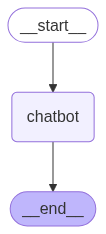

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
from langchain_core.tools import tool

In [14]:
@tool
def llm_calculator_tool(inputs):
    """
    A simple two-input calculator tool that delegates arithmetic operations to an LLM.

    Args:
        inputs: A dictionary with the following keys:
            operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
            num1 (float): The first number.
            num2 (float): The second number.

    Returns:
        dict: A dictionary containing the operation, inputs, and the result.
    """
    operation = inputs.get('operation')
    num1 = inputs.get('num1')
    num2 = inputs.get('num2')

    # Validate inputs
    if operation not in ['add', 'subtract', 'multiply', 'divide']:
        return {"error": "Invalid operation. Choose from 'add', 'subtract', 'multiply', or 'divide'."}
    if not isinstance(num1, (int, float)) or not isinstance(num2, (int, float)):
        return {"error": "Inputs 'num1' and 'num2' must be numbers."}
    if operation == 'divide' and num2 == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = num1 + num2
    elif operation == 'subtract':
        result = num1 - num2
    elif operation == 'multiply':
        result = num1 * num2
    elif operation == 'divide':
        result = num1 / num2

    return {
        "operation": operation,
        "num1": num1,
        "num2": num2,
        "result": result
    }
llm_calculator_tool.args_schema.model_json_schema()

{'description': "A simple two-input calculator tool that delegates arithmetic operations to an LLM.\n\nArgs:\n    inputs: A dictionary with the following keys:\n        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').\n        num1 (float): The first number.\n        num2 (float): The second number.\n\nReturns:\n    dict: A dictionary containing the operation, inputs, and the result.",
 'properties': {'inputs': {'title': 'Inputs'}},
 'required': ['inputs'],
 'title': 'llm_calculator_tool',
 'type': 'object'}

In [15]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

In [16]:
tools=[llm_calculator_tool]

In [17]:
tool_node= ToolNode(tools=tools)

In [18]:
llm_with_tools= llm.bind_tools(tools=tools)


In [19]:
def call_model(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools.invoke(message)
   return {"messages": [response]}

In [20]:
def should_continue(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools"
  return END

In [21]:
workflows = StateGraph(MessagesState)
workflows.add_node("agent", call_model)
workflows.add_node("tools", tool_node)
workflows.add_edge(START, "agent")
workflows.add_conditional_edges("agent", should_continue, ["tools",END])
workflows.add_edge("tools", "agent")

In [22]:
ai= workflows.compile()

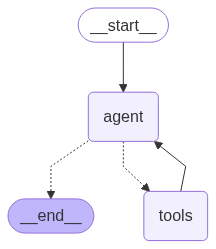

In [23]:
from IPython.display import Image, display
display(Image(ai.get_graph().draw_mermaid_png()))

In [24]:
pip install -U langchain-tavily

In [ ]:
import os


os.environ["TAVILY_API_KEY"] = ""



In [26]:
from langchain_tavily import TavilySearch

searchtool = TavilySearch(max_results=2)
tools1 = [searchtool]

In [27]:
tool_node1= ToolNode(tools=tools1)
llm_with_tools1= llm_with_tools.bind_tools(tools=tools1)

In [28]:
def call_model1(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools1.invoke(message)
   return {"messages": [response]}

In [29]:
def should_continue1(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools1"
  return END

In [30]:
workflows.add_node("tools1", tool_node1)
workflows.add_conditional_edges("agent", should_continue1, ["tools1",END])
workflows.add_edge("tools1", "agent")

In [31]:
ai1=workflows.compile()

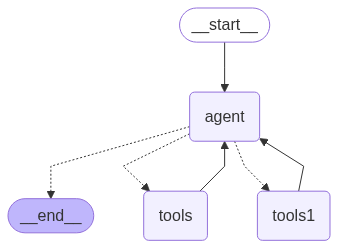

In [32]:
from IPython.display import Image, display
display(Image(ai1.get_graph().draw_mermaid_png()))

In [33]:
searchtool.invoke("what is trending in tokyo fashion")

{'query': 'what is trending in tokyo fashion',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Tokyo Is My Second Home, and These Are the 5 Summer 2024 Fashion Trends',
   'url': 'https://www.instyle.com/tokyo-summer-2024-fashion-trends-8659417',
   'content': 'Tokyo Is My Second Home, and Everyone in Japan Is Wearing These 5 Breezy Summer Trends The first thing you notice when you step off the plane in Tokyo is that everyone is wearing wide-leg pants. While here in the West it’s more common to style wide-leg pants with fitted tops, in Japan they keep everything rather loose. It’s not common for women to wear flat shoes to work, and three-plus-inch heels begin to stand out too much (which, contrary to New York fashion, is not desired). Absolutely no one is complaining when there are such cute options such as this bowtie slingback from Reformation or ridiculously comfy chunky heel from Vivaia—seriously, I saw at least ten people wearing this exact s

In [34]:
pip install pyowm

In [35]:
pip install langchain-community

In [ ]:
import os

from langchain_community.utilities import OpenWeatherMapAPIWrapper

os.environ["OPENWEATHERMAP_API_KEY"] = ""
import google.generativeai as genai
genai.configure(api_key=os.getenv('OPENWEATHERMAP_API_KEY'))

weather = OpenWeatherMapAPIWrapper()
tools2 = [weather.run]

In [37]:
tool_node2= ToolNode(tools=tools2)
llm_with_tools2= llm_with_tools1.bind_tools(tools=tools2)

In [38]:
def call_model2(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools2.invoke(message)
   return {"messages": [response]}

In [39]:
def should_continue2(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools2"
  return END

In [40]:
workflows.add_node("tools2", tool_node2)
workflows.add_conditional_edges("agent", should_continue2, ["tools2",END])
workflows.add_edge("tools2", "agent")

In [41]:
ai2=workflows.compile()

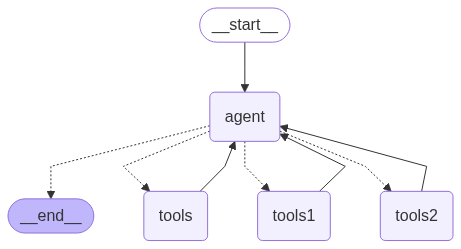

In [42]:
from IPython.display import Image, display
display(Image(ai2.get_graph().draw_mermaid_png()))

In [43]:
weather.run("Delhi")

'In Delhi, the current weather is as follows:\nDetailed status: mist\nWind speed: 2.06 m/s, direction: 50°\nHumidity: 83%\nTemperature: \n  - Current: 28.05°C\n  - High: 28.05°C\n  - Low: 28.05°C\n  - Feels like: 32.71°C\nRain: {}\nHeat index: None\nCloud cover: 8%'

In [44]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [45]:
ai3=workflows.compile(checkpointer=memory)

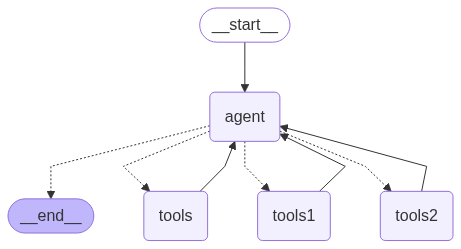

In [46]:
from IPython.display import Image, display
display(Image(ai3.get_graph().draw_mermaid_png()))

**FINAL AI CREATION AND ADDING MORE AGENTS AND RUNNING SOME PROMPTS**

In [47]:
tools_final = [llm_calculator_tool,searchtool, weather.run]
llm_with_tools_final = llm.bind_tools(tools=tools_final)


In [48]:
def call_model_final(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools_final.invoke(message)
   return {"messages": [response]}

In [49]:
def should_continue_final(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools"
  return END

In [50]:
tool_node_final= ToolNode(tools=tools_final)

In [51]:
workflows_final = StateGraph(MessagesState)
workflows_final.add_node("agent", call_model_final)
workflows_final.add_node("tools", tool_node_final)
workflows_final.add_edge(START, "agent")
workflows_final.add_conditional_edges("agent", should_continue_final, ["tools",END])
workflows_final.add_edge("tools", "agent")

In [52]:
ai_final=workflows_final.compile()

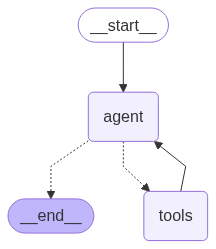

In [53]:
from IPython.display import Image, display
display(Image(ai_final.get_graph().draw_mermaid_png()))

In [54]:
ai_final=workflows_final.compile(checkpointer=memory)

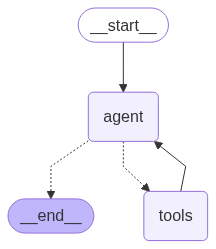

In [55]:
from IPython.display import Image, display
display(Image(ai_final.get_graph().draw_mermaid_png()))

In [56]:
from langchain_core.messages import HumanMessage


In [57]:
from langchain_core.messages import HumanMessage

ai_final.invoke({
    "messages": [HumanMessage(content="What's the weather in Delhi?")]
}, config={"configurable": {"thread_id": "abc"}})

ai_final.invoke({
    "messages": [HumanMessage(content="Add 15 and 27")]
}, config={"configurable": {"thread_id": "abc"}})

ai_final.invoke({
    "messages": [HumanMessage(content="What are the latest fashion trends in Paris?")]
}, config={"configurable": {"thread_id": "abc"}})

{'messages': [HumanMessage(content="What's the weather in Delhi?", additional_kwargs={}, response_metadata={}, id='49bee1d3-b3f1-4a48-a0af-64b2b26d1aa5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'run', 'arguments': '{"location": "Delhi"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--ab875b18-32d5-49fd-9303-00d267f8fbd2-0', tool_calls=[{'name': 'run', 'args': {'location': 'Delhi'}, 'id': '5faaa799-f1b4-40c5-b9db-f34d4bcecbf9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 608, 'output_tokens': 3, 'total_tokens': 611, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='In Delhi, the current weather is as follows:\nDetailed status: mist\nWind speed: 2.06 m/s, direction: 50°\nHumidity: 83%\nTemperature: \n  - Current: 28.05°C\n  - High: 28.05°C\n  - Low: 28.05°C\n  - Feels like: 32.71°C\nRain: {}\nHeat index: 

See the ToolMessage content in each

In [58]:
searchtool_general = TavilySearch(max_results=2)
tools_agent2 = [searchtool_general]

In [59]:
tool_node_agent2= ToolNode(tools=tools_agent2)
llm_with_tools_agent2= llm_with_tools_final.bind_tools(tools=tools_agent2)

In [60]:
def call_model_agent2(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools_agent2.invoke(message)
   return {"messages": [response]}

In [61]:
def should_continue_agent2(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools_agent2"
  return END

In [62]:
workflows_final.add_node("agent2", call_model_agent2)
workflows_final.add_node("tools_agent2", tool_node_agent2)
workflows_final.add_edge(START, "agent2")
workflows_final.add_conditional_edges("agent2", should_continue_agent2, ["tools_agent2",END])
workflows_final.add_edge("tools_agent2", "agent2")

In [63]:
ai_final=workflows_final.compile(checkpointer=memory)

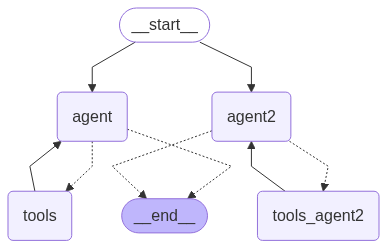

In [64]:
from IPython.display import Image, display
display(Image(ai_final.get_graph().draw_mermaid_png()))

In [66]:
@tool
def llm_intro_tool():
  """
  Prints an introduction about the creator of the system.
  """
  print("Hi, the creator of this entire system is me- Shubham Rane! I am from the CSE department at IIT Guwahati of the 2028 passing out branch. I am originally from Mumbai but at IITG, I reside at Brahmaputra hostel." )

In [67]:
tools_agent3=[llm_intro_tool]

In [68]:
tool_node_agent3= ToolNode(tools=tools_agent3)
llm_with_tools_agent3= llm_with_tools_agent2.bind_tools(tools=tools_agent3)

In [69]:
def call_model_agent3(state: MessagesState):
   message= state["messages"]
   response= llm_with_tools_agent3.invoke(message)
   return {"messages": [response]}

In [70]:
def should_continue_agent3(state: MessagesState):
  message = state["messages"]
  last_message = message[-1]
  if last_message.tool_calls:
    return "tools_agent3"
  return END

In [71]:
workflows_final.add_node("agent3", call_model_agent3)
workflows_final.add_node("tools_agent3", tool_node_agent3)
workflows_final.add_edge(START, "agent3")
workflows_final.add_conditional_edges("agent3", should_continue_agent3, ["tools_agent3",END])
workflows_final.add_edge("tools_agent3", "agent3")

In [72]:
ai_final=workflows_final.compile(checkpointer=memory)

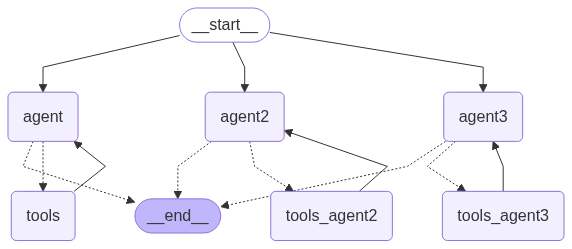

In [73]:
from IPython.display import Image, display
display(Image(ai_final.get_graph().draw_mermaid_png()))

A prompt to call agent 3 showing the entire system (prompts called until now)

In [74]:
ai_final.invoke({
    "messages": [HumanMessage(content="Who is the creator of this system")]
}, config={"configurable": {"thread_id": "abc"}})

Hi, the creator of this entire system is me- Shubham Rane! I am from the CSE department at IIT Guwahati of the 2028 passing out branch. I am originally from Mumbai but at IITG, I reside at Brahmaputra hostel.


{'messages': [HumanMessage(content="What's the weather in Delhi?", additional_kwargs={}, response_metadata={}, id='49bee1d3-b3f1-4a48-a0af-64b2b26d1aa5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'run', 'arguments': '{"location": "Delhi"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--ab875b18-32d5-49fd-9303-00d267f8fbd2-0', tool_calls=[{'name': 'run', 'args': {'location': 'Delhi'}, 'id': '5faaa799-f1b4-40c5-b9db-f34d4bcecbf9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 608, 'output_tokens': 3, 'total_tokens': 611, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='In Delhi, the current weather is as follows:\nDetailed status: mist\nWind speed: 2.06 m/s, direction: 50°\nHumidity: 83%\nTemperature: \n  - Current: 28.05°C\n  - High: 28.05°C\n  - Low: 28.05°C\n  - Feels like: 32.71°C\nRain: {}\nHeat index: 

Top most line giving the most recent response